### Load realistic dose map

In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import pydicom

import torch

# 1) Path to your RTDOSE DICOM
dose_path = "/database/brainmets/dicom/Data/SRS0871/1997-07__Studies/" \
            "SRS0871_SRS0871_RTDOSE_1997-07-18_000000_._._n1__00000/" \
            "2.16.840.1.114362.1.12046989.25631758973.631597914.728.2236.dcm"

# 2) Read as an image
dose_img = sitk.ReadImage(dose_path)

# 3) Convert to NumPy (this is your 3D array: [z, y, x])
dose_arr = sitk.GetArrayFromImage(dose_img)

# 4) Get geometry info
size = dose_img.GetSize()         # (x, y, z) in voxels
spacing = dose_img.GetSpacing()   # (sx, sy, sz) in mm
origin = dose_img.GetOrigin()     # (x0, y0, z0) in mm
direction = dose_img.GetDirection()  # 3x3 direction cosines (flattened tuple)

# 5) Print everything nicely
print("NumPy array shape (z, y, x):", dose_arr.shape)  # 3D array
print("Image size (x, y, z):", size)
print("Voxel spacing / resolution (mm) (sx, sy, sz):", spacing)
print("Origin (mm) (x0, y0, z0):", origin)
print("Direction cosines (row-major 3x3):", direction)

# 6) Print min/max before rescaling (in arbitrary units)
print("\nBefore rescaling (a.u.):")
print(f"  Min: {np.min(dose_arr):.2f}")
print(f"  Max: {np.max(dose_arr):.2f}")

# 7) Get DoseGridScaling factor from DICOM file to convert to Gy
dicom_dataset = pydicom.dcmread(dose_path)
dose_grid_scaling = float(dicom_dataset.DoseGridScaling)

# 8) Rescale dose array to Gy
dose_arr = dose_arr * dose_grid_scaling

# 9) Print min/max after rescaling (in Gy)
print("\nAfter rescaling (Gy):")
print(f"  Min: {np.min(dose_arr):.4f} Gy")
print(f"  Max: {np.max(dose_arr):.4f} Gy")
print(f"  DoseGridScaling factor: {dose_grid_scaling}")

# If you really want (x, y, z) order in NumPy instead of (z, y, x):
dose_arr_xyz = np.moveaxis(dose_arr, 0, -1)  # shape (y, x, z) or adjust as you prefer
print("dose_arr is 3D:", dose_arr.ndim == 3)


NumPy array shape (z, y, x): (267, 388, 361)
Image size (x, y, z): (361, 388, 267)
Voxel spacing / resolution (mm) (sx, sy, sz): (0.5, 0.5, 0.5)
Origin (mm) (x0, y0, z0): (63.2970939, 41.0714023, 7.50189248)
Direction cosines (row-major 3x3): (1.0, -4.13237851e-17, 8.7805075e-19, 4.13237851e-17, 1.0, -8.48640832e-19, 8.7805075e-19, -8.48640832e-19, -1.0)

Before rescaling (a.u.):
  Min: 0.00
  Max: 65535.00

After rescaling (Gy):
  Min: 0.0000 Gy
  Max: 36.2124 Gy
  DoseGridScaling factor: 0.000552565549
dose_arr is 3D: True


0.0 35.319437326530995


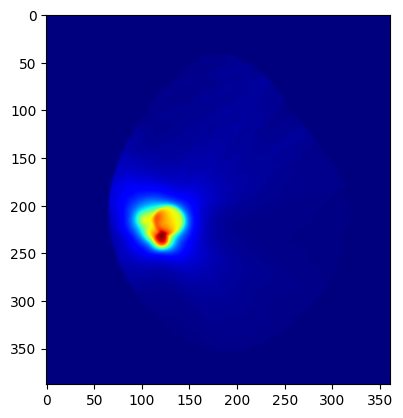

In [2]:
plt.figure()
plt.imshow(dose_arr_xyz[:,:,55], cmap='jet')

print(np.min(dose_arr_xyz[:,:,55]), np.max(dose_arr_xyz[:,:,55]))

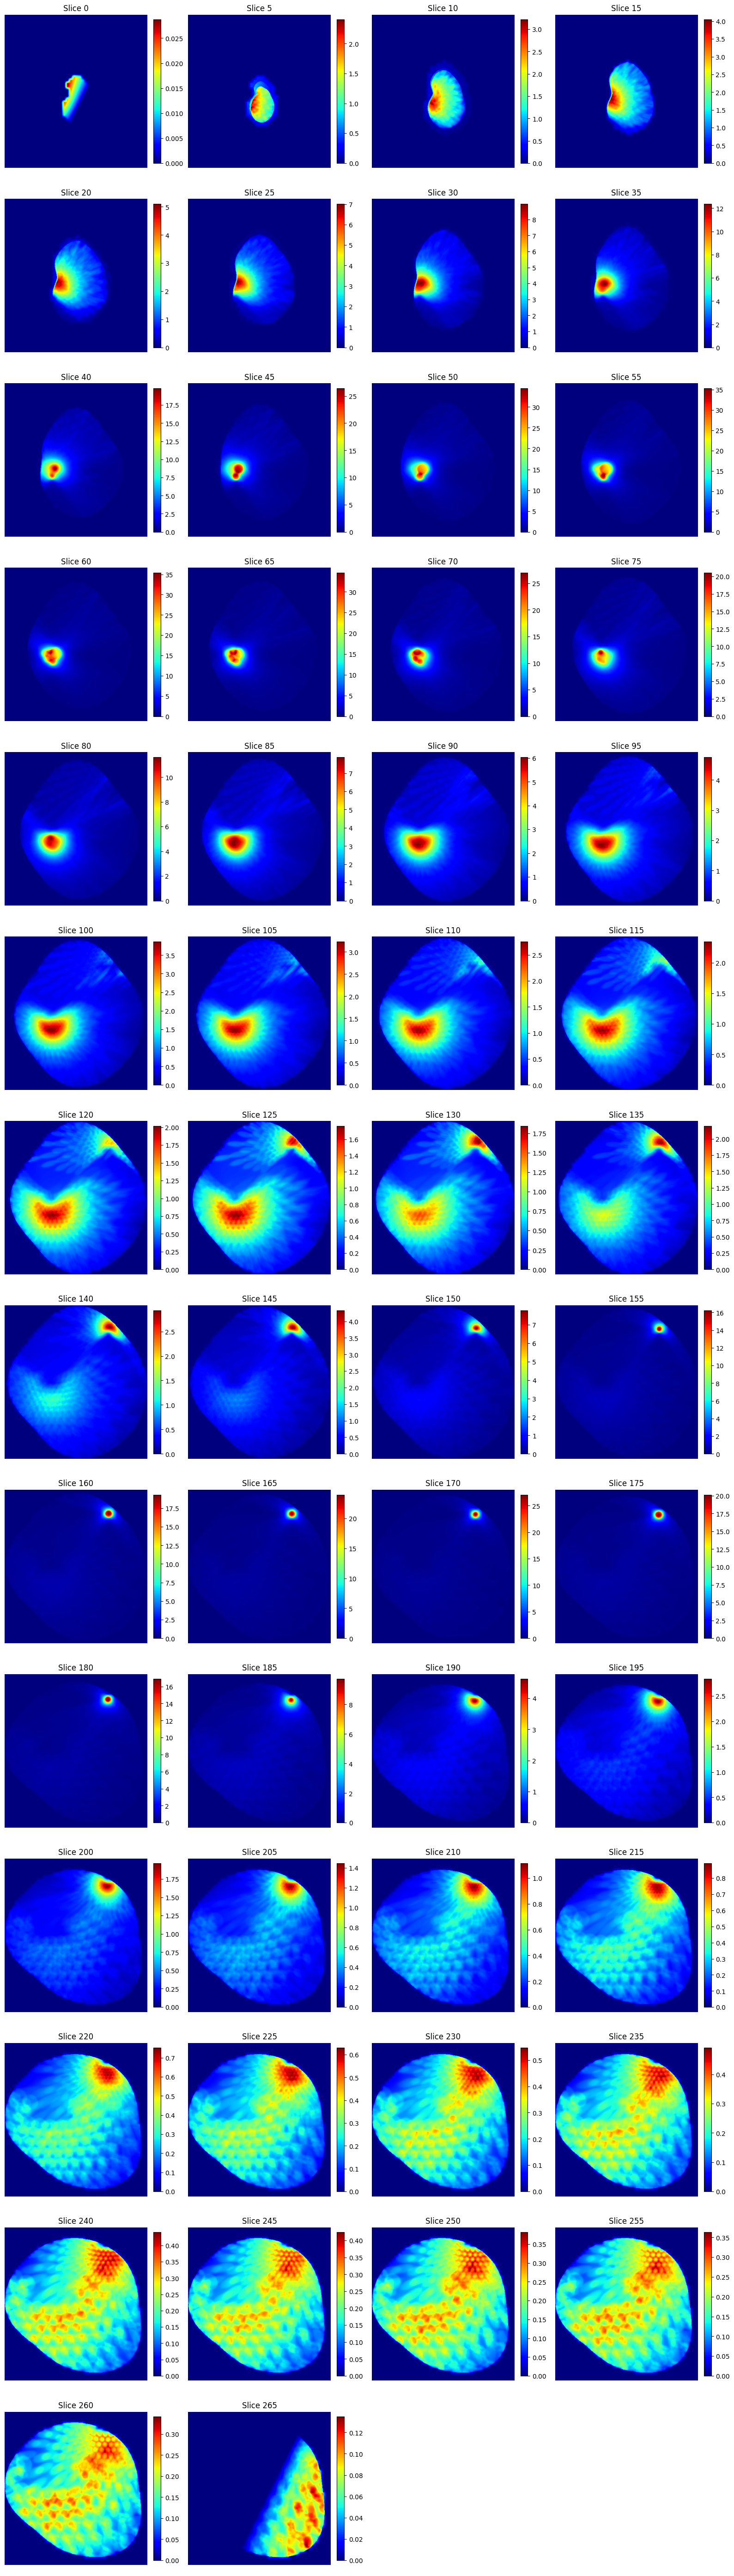

In [3]:
# Display dose map every 5 slices with colorbars
import matplotlib.pyplot as plt
import numpy as np

# Get slice indices every 5 slices
num_slices = dose_arr_xyz.shape[2]  # Last dimension is slice
slice_indices = np.arange(0, num_slices, 5)

# Calculate grid dimensions for subplots
n_slices = len(slice_indices)
n_cols = 4  # Number of columns in the grid
n_rows = int(np.ceil(n_slices / n_cols))

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten() if n_slices > 1 else [axes] if n_rows == 1 and n_cols == 1 else axes.flatten()

# Display each slice
for idx, slice_idx in enumerate(slice_indices):
    ax = axes[idx]
    im = ax.imshow(dose_arr_xyz[:, :, slice_idx], cmap='jet')
    ax.set_title(f'Slice {slice_idx}')
    ax.axis('off')
    
    # Add colorbar to each slice
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Hide unused subplots
for idx in range(n_slices, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [4]:
dose = dose_arr_xyz[:,:,55]
DIM0, DIM1 = dose.shape

dose = torch.from_numpy(dose).unsqueeze(0).unsqueeze(0).to(torch.float32)

print(dose.shape)
print(dose.dtype)

torch.Size([1, 1, 388, 361])
torch.float32


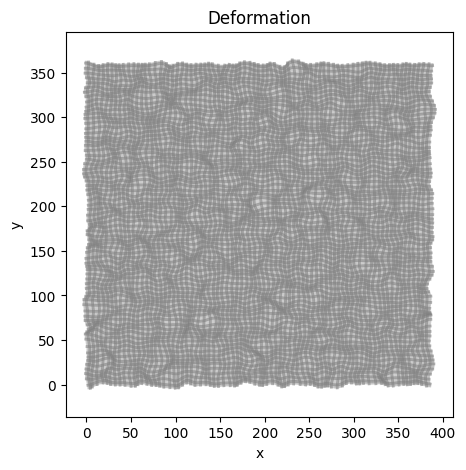

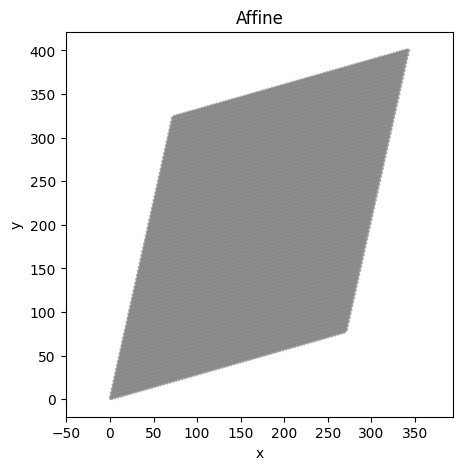

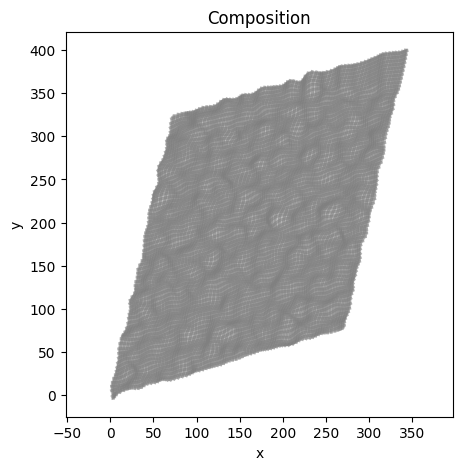

In [5]:
import torch
import matplotlib.pyplot as plt

import composable_mapping as cm
from torchvision.transforms import GaussianBlur



# DIM0 = 192
# DIM1 = 256



# coordinate_system = cm.CoordinateSystem.centered_normalized(spatial_shape=(256, 256))
coordinate_system = cm.CoordinateSystem.voxel((DIM0, DIM1)).multiply_world(
    torch.tensor([1, 1], dtype=torch.float32)
)
deformation = cm.samplable_volume(
    GaussianBlur(kernel_size=21, sigma=5.0)(20 * torch.randn(1, 2, DIM0, DIM1)),
    coordinate_system=coordinate_system,
    data_format=cm.DataFormat.voxel_displacements(),
)
affine = cm.affine(torch.tensor([[0.7, 0.2, 0.0], [0.2, 0.9, 0.0], [0.0, 0.0, 1.0]]))
composition = deformation @ affine
cm.visualize_as_deformed_grid(deformation)
plt.title("Deformation")
plt.show()
cm.visualize_to_as_deformed_grid(affine, target=coordinate_system)
plt.title("Affine")
plt.show()
cm.visualize_as_deformed_grid(composition)
plt.title("Composition")
plt.show()

In [6]:
# composable-mapping demo: multi-resolution dose + fine contour, 2D
# Requires: pip install composable-mapping torch matplotlib

import math
import torch
import numpy as np
import matplotlib.pyplot as plt

import composable_mapping as cm


# =========================
# Compatibility helpers
# =========================
def cs_grid(cs):
    """Return CoordinateSystem grid as a MappableTensor (handles property/method)."""
    g = getattr(cs, "grid")
    return g() if callable(g) else g

def cs_shape(cs):
    """Return (H, W[, ...]) regardless of property/method API."""
    s = getattr(cs, "spatial_shape")
    return s() if callable(s) else s

def cs_spacing(cs):
    """Return spacing tensor regardless of property/method API or CPU/GPU variant."""
    f = getattr(cs, "grid_spacing", None) or getattr(cs, "grid_spacing_cpu", None)
    if f is None:
        raise AttributeError("CoordinateSystem has no grid_spacing[ _cpu ] accessor")
    return f() if callable(f) else f

def mt_from_tensor(t, n_channel_dims=1):
    """Create a MappableTensor from a tensor, across versions."""
    if hasattr(cm, "mappable"):
        return cm.mappable(t, n_channel_dims=n_channel_dims)
    # Fallback: older/newer API name
    return cm.MappableTensor.from_tensor(t, n_channel_dims=n_channel_dims)

def get_sampler(name="linear"):
    """Version-safe access to samplers."""
    # Directly instantiate the interpolator classes
    return cm.NearestInterpolator() if name == "nearest" else cm.LinearInterpolator()


# =========================
# Coordinate systems & data
# =========================
def make_coordinate_systems(H=128, W=160, img_spacing_mm=1.0, dose_spacing_mm=0.5):
    """
    Two grids with identical physical FOV:
      - image grid: (H, W), spacing = img_spacing_mm
      - dose  grid: (Hd, Wd), spacing = dose_spacing_mm (denser grid)
    Origin = (0,0), orientation = identity (world in mm).
    """
    img_cs = cm.CoordinateSystem.voxel((H, W)).multiply_world(
        torch.tensor([img_spacing_mm, img_spacing_mm], dtype=torch.float32)
    )
    Hd = int(round(H * img_spacing_mm / dose_spacing_mm))
    Wd = int(round(W * img_spacing_mm / dose_spacing_mm))
    dose_cs = cm.CoordinateSystem.voxel((Hd, Wd)).multiply_world(
        torch.tensor([dose_spacing_mm, dose_spacing_mm], dtype=torch.float32)
    )

    # Optional FOV sanity check
    img_fov = torch.tensor([H * img_spacing_mm, W * img_spacing_mm])
    dose_fov = torch.tensor([Hd * dose_spacing_mm, Wd * dose_spacing_mm])
    if not torch.allclose(img_fov, dose_fov, atol=1e-3):
        print(f"[warn] FOV mismatch: img {img_fov.tolist()} mm vs dose {dose_fov.tolist()} mm")

    return img_cs, dose_cs

def make_synthetic_dose_smooth(dose_cs):
    """
    Create a smooth toy 'dose' on the dose grid (same physical FOV as image),
    using world-mm coordinates from the coordinate system.
    """
    gyx_mt = cs_grid(dose_cs)             # MappableTensor of world coords (y,x)
    gyx = gyx_mt.generate_values()        # Materialize -> Tensor
    # Expect shape [..., 2, H, W]
    if gyx.shape[-3] != 2:
        raise RuntimeError(f"Expected coord channels=2 at dim -3, got shape {gyx.shape}")
    y = gyx[..., 0, :, :]
    x = gyx[..., 1, :, :]

    H, W = y.shape[-2:]
    sy, sx = cs_spacing(dose_cs)
    cy, cx = (sy * H) / 2.0, (sx * W) / 2.0

    g1 = torch.exp(-((y - cy) ** 2 + (x - cx) ** 2) / (2.0 * 15.0 ** 2))
    g2 = 0.6 * torch.exp(-((y - 0.35 * 2 * cy) ** 2 + (x - 0.65 * 2 * cx) ** 2) / (2.0 * 10.0 ** 2))
    dose = (g1 + g2).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return dose.contiguous()

def make_synthetic_dose(dose_cs):
    """
    Create a smooth toy 'dose' on the dose grid (same physical FOV as image),
    using world-mm coordinates from the coordinate system.
    Now has three centers, with the third having a sharp dose gradient.
    """
    gyx_mt = cs_grid(dose_cs)             # MappableTensor of world coords (y,x)
    gyx = gyx_mt.generate_values()        # Materialize -> Tensor
    # Expect shape [..., 2, H, W]
    if gyx.shape[-3] != 2:
        raise RuntimeError(f"Expected coord channels=2 at dim -3, got shape {gyx.shape}")
    y = gyx[..., 0, :, :]
    x = gyx[..., 1, :, :]

    H, W = y.shape[-2:]
    sy, sx = cs_spacing(dose_cs)
    cy, cx = (sy * H) / 2.0, (sx * W) / 2.0

    # Broad central Gaussian
    g1 = torch.exp(-((y - cy) ** 2 + (x - cx) ** 2) / (2.0 * 15.0 ** 2))

    # Second, slightly smaller Gaussian off-center
    g2 = 0.6 * torch.exp(
        -((y - 0.35 * 2 * cy) ** 2 + (x - 0.65 * 2 * cx) ** 2) / (2.0 * 10.0 ** 2)
    )

    # Third Gaussian with sharp dose gradient (small sigma)
    sharp_sigma = 3.0  # mm; smaller -> steeper gradient
    sharp_cy = 0.2 * 2 * cy
    sharp_cx = 0.25 * 2 * cx
    g3 = 0.8 * torch.exp(
        -((y - sharp_cy) ** 2 + (x - sharp_cx) ** 2) / (2.0 * sharp_sigma ** 2)
    )

    dose = (g1 + g2 + g3).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return dose.contiguous()


def make_circle_contour(center_yx_mm, radius_mm, step_mm=0.1):
    """
    Return Nx2 world coordinates (in mm) for a circle with arc-length spacing ~step_mm.
    center_yx_mm: (y, x) in mm
    """
    circumference = 2.0 * math.pi * radius_mm
    n = max(16, int(round(circumference / step_mm)))
    # Older torch doesn't support endpoint=. Emulate [0, 2π) by dropping last point.
    thetas = torch.linspace(0.0, 2.0 * math.pi, n + 1, dtype=torch.float32)[:-1]
    y = center_yx_mm[0] + radius_mm * torch.sin(thetas)
    x = center_yx_mm[1] + radius_mm * torch.cos(thetas)
    return torch.stack([y, x], dim=-1)  # [N, 2] world coords in mm

In [7]:
print(dose.shape)

torch.Size([1, 1, 388, 361])


In [8]:
# img_cs, dose_cs = make_coordinate_systems(DIM0, DIM1, img_spacing_mm=2.0, dose_spacing_mm=1.0)
# dose_cs


img_spacing_mm = 2.0
img_cs = cm.CoordinateSystem.voxel((DIM0//2, DIM1//2)).multiply_world(
    torch.tensor([img_spacing_mm, img_spacing_mm], dtype=torch.float32)
)


dose_spacing_mm = 1.0
dose_cs = cm.CoordinateSystem.voxel((DIM0, DIM1)).multiply_world(
    torch.tensor([dose_spacing_mm, dose_spacing_mm], dtype=torch.float32)
)

dose_cs

CoordinateSystem(spatial_shape=(388, 361), to_voxel_coordinates=HostDiagonalAffineTransformation(definition=DiagonalAffineMatrixDefinition(diagonal=tensor([1., 1.]), translation=None, matrix_shape=torch.Size([3, 3]), dtype=torch.float32, device=cpu)), from_voxel_coordinates=Affine(transformation=HostDiagonalAffineTransformation(definition=DiagonalAffineMatrixDefinition(diagonal=tensor([1., 1.]), translation=None, matrix_shape=torch.Size([3, 3]), dtype=torch.float32, device=cpu))))

In [9]:
print("dose tensor dtype:", dose.dtype)

# Sample some values from the samplable volume
sampled = dose_image_halfres.sample()
print("samplable dose dtype:", sampled.displacements.dtype if hasattr(sampled, "displacements") else sampled.generate_values().dtype)

# Check grid dtype
g = dose_cs.grid.generate_values()
print("grid dtype:", g.dtype)


dose tensor dtype: torch.float32


NameError: name 'dose_image_halfres' is not defined

In [10]:

### coordinate system
# img_cs, dose_cs = make_coordinate_systems(DIM0, DIM1, img_spacing_mm=1.0, dose_spacing_mm=0.5)
# img_cs, dose_cs = make_coordinate_systems(DIM0, DIM1, img_spacing_mm=2.0, dose_spacing_mm=1.0)

# Synthetic high-res dose on its own grid (0.5 mm)
# dose = make_synthetic_dose(dose_cs)  # [1,1,Hd,Wd]

# dose_image_fullres = cm.samplable_volume(
#     dose[0,...],
#     coordinate_system=dose_cs,
# )

dose_image_fullres = cm.samplable_volume(
    dose,
    coordinate_system=dose_cs,
)

# dose_image_halfres = cm.samplable_volume(
#     dose[0,...],
#     coordinate_system=img_cs,
# )
# ValueError: Coordinate system spatial shape must match the data spatial shape. Coordinate system spatial shape: (192, 256), data spatial shape: (384, 512).
dose_image_halfres = dose_image_fullres.resample_to(img_cs)



# deformed_dose_image_fullres = dose_image_fullres @ composition
# deformed_dose_image_halfres = dose_image_halfres @ composition

deformed_dose_image_fullres = dose_image_fullres @ deformation
deformed_dose_image_halfres = dose_image_halfres @ deformation

deformed_dose_image_halfres_resampled = deformed_dose_image_halfres.resample_to(dose_cs)

In [ ]:
print(dose_image_fullres.sample().displacements)

torch.Size([1, 1, 388, 361])


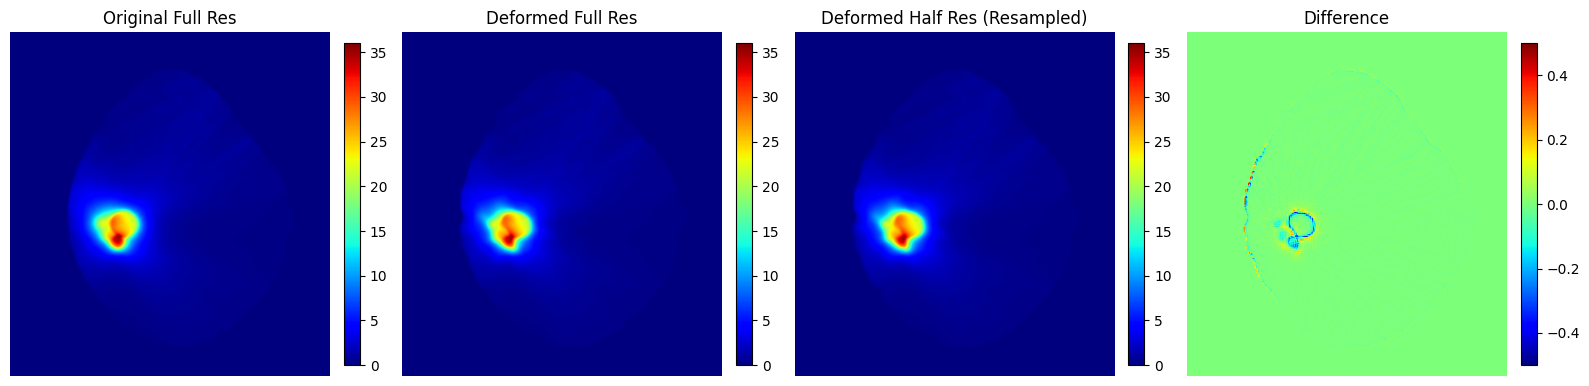

In [16]:
diff = deformed_dose_image_fullres.sample() - deformed_dose_image_halfres_resampled.sample()
print(diff.shape)

# Define color limits
vmin_dose = 0
vmax_dose = 36
vmin_diff = -0.5
vmax_diff = 0.5

cmap = 'jet'
# cmap = 'bwr'

# Create figure with 4 subplots in one row
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot 1: Original full resolution dose
ax1 = axes[0]
im1 = ax1.imshow(
    dose_image_fullres.sample().displacements.numpy().squeeze(),
    cmap=cmap, vmin=vmin_dose, vmax=vmax_dose
)
ax1.set_title('Original Full Res')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# Plot 2: Deformed full resolution dose
ax2 = axes[1]
im2 = ax2.imshow(
    deformed_dose_image_fullres.sample().displacements.numpy().squeeze(),
    cmap=cmap, vmin=vmin_dose, vmax=vmax_dose
)
ax2.set_title('Deformed Full Res')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

# Plot 3: Deformed half resolution resampled dose
ax3 = axes[2]
im3 = ax3.imshow(
    deformed_dose_image_halfres_resampled.sample().displacements.numpy().squeeze(),
    cmap=cmap, vmin=vmin_dose, vmax=vmax_dose
)
ax3.set_title('Deformed Half Res (Resampled)')
ax3.axis('off')
plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

# Plot 4: Difference
ax4 = axes[3]
diff = deformed_dose_image_halfres_resampled.sample().displacements.numpy().squeeze() - deformed_dose_image_fullres.sample().displacements.numpy().squeeze()
im4 = ax4.imshow(
    diff,
    cmap=cmap, vmin=vmin_diff, vmax=vmax_diff
)
ax4.set_title('Difference')
ax4.axis('off')
plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [ ]:
# We flip the coordinates for visualization for the image to show correct size up
visualization_coordinates = coordinate_system.transform_world_with_diagonal_matrix(
    torch.tensor([-1.0, 1.0])
)
fig = cm.visualize_to_as_image(dose_image, target=coordinate_system)
fig.suptitle("Original")
plt.show()
fig = cm.visualize_to_as_image(deformed_dose_image_fullres, target=coordinate_system)
fig.suptitle("Deformed full res")
plt.show()
fig = cm.visualize_to_as_image(deformed_dose_image_halfres, target=coordinate_system)
fig.suptitle("Deformed half res")
plt.show()

fig = cm.visualize_to_as_image(deformed_dose_image_halfres_resampled, target=coordinate_system)
fig.suptitle("Deformed half res (resampled)")
plt.show()
fig = cm.visualize_to_as_image(deformed_dose_image_halfres_resampled-deformed_dose_image_fullres, target=coordinate_system)
fig.suptitle("Deformed half res (resampled)")
plt.show()

In [ ]:
deformed_dose_image_halfres_resampled